# Prediction Intervals for Quantile Regression Forests

This example shows how quantile regression can be used to create prediction
intervals. Note that this is an adapted example from Gradient Boosting regression
with quantile loss. The procedure and conclusions remain almost exactly the same.

Generate some data for a synthetic regression problem by applying the
function f to uniformly sampled random inputs.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

To make the problem interesting, we generate observations of the target y as
the sum of a deterministic term computed by the function f and a random noise
term that follows a centered `log-normal
<https://en.wikipedia.org/wiki/Log-normal_distribution>`_. To make this even
more interesting we consider the case where the amplitude of the noise
depends on the input variable x (heteroscedastic noise).

The lognormal distribution is non-symmetric and long tailed: observing large
outliers is likely but it is impossible to observe small outliers.

In [3]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma ** 2 / 2)
y = expected_y + noise

Split into train, test datasets:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Fitting non-linear quantile and least squares regressors

Fit a Random Forest Regressor and Quantile Regression Forest based on the same parameterisation.

In [5]:
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

In [6]:
common_params = dict(
    max_depth=3,
    min_samples_leaf=4,
    min_samples_split=4,
)
qrf = RandomForestQuantileRegressor(**common_params, q=[0.05, 0.5, 0.95])
qrf.fit(X_train, y_train)

RandomForestQuantileRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=4, quantiles=[0.05, 0.5, 0.95], method='default')

For the sake of comparison, also fit a standard Regression Forest

In [7]:
rf = RandomForestRegressor(**common_params)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=4)

Create an evenly spaced evaluation set of input values spanning the [0, 10] range.

In [8]:
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

All quantile predictions are done simultaneously.

In [9]:
predictions = qrf.predict(xx)

Plot the true conditional mean function f, the prediction of the conditional mean (least squares loss),
the conditional median and the conditional 90% interval (from 5th to 95th conditional percentiles).

/tmp/ipykernel_69250/1410534679.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xx, y_med, 'r-', label='Predicted median', color="orange")


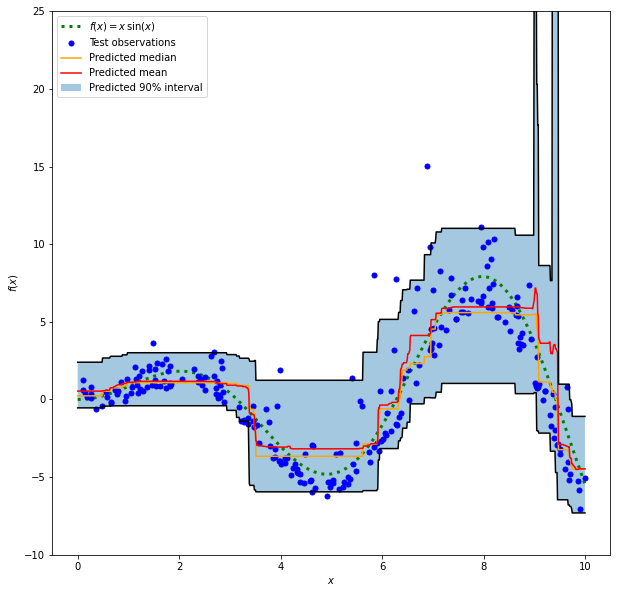

In [10]:
import matplotlib.pyplot as plt

y_pred = rf.predict(xx)
y_lower = predictions[0]
y_med = predictions[1]
y_upper = predictions[2]

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), 'g:', linewidth=3, label=r'$f(x) = x\,\sin(x)$')
plt.plot(X_test, y_test, 'b.', markersize=10, label='Test observations')
plt.plot(xx, y_med, 'r-', label='Predicted median', color="orange")
plt.plot(xx, y_pred, 'r-', label='Predicted mean')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill_between(xx.ravel(), y_lower, y_upper, alpha=0.4,
                 label='Predicted 90% interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 25)
plt.legend(loc='upper left')
plt.show()

Comparing the predicted median with the predicted mean, we note that the median is on average below the mean as the noise is skewed towards high values (large outliers). The median estimate also seems to be smoother because of its natural robustness to outliers.

## Analysis of the error metrics

Measure the models with :func:`sklearn.mean_squared_error` and
:func:`sklearn.mean_pinball_loss` metrics on the training dataset.

In [11]:
import pandas as pd

def highlight_min(x):
    x_min = x.min()
    return ['font-weight: bold' if v == x_min else ''
            for v in x]


results = []
for i, model in enumerate(["q 0.05", "q 0.5", "q 0.95", "rf"]):
    metrics = {'model': model}
    if model == "rf":
        y_pred = rf.predict(X_train)
    else:
        y_pred = qrf.predict(X_train)[i]
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(
            y_train, y_pred, alpha=alpha)
    metrics['MSE'] = mean_squared_error(y_train, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index('model').style.apply(highlight_min)

NameError: name 'pd' is not defined

One column shows all models evaluated by the same metric. The minimum number on a column should
be obtained when the model is trained and measured with
the same metric. This should be always the case on the training set if the training converged.

Note that because the target distribution is asymmetric, the expected
conditional mean and conditional median are signficiantly different and
therefore one could not use the least squares model get a good estimation of
the conditional median nor the converse.

If the target distribution were symmetric and had no outliers (e.g. with a
Gaussian noise), then median estimator and the least squares estimator would
have yielded similar predictions.

We then do the same on the test set.

In [12]:
results = []
for i, model in enumerate(["q 0.05", "q 0.5", "q 0.95", "rf"]):
    metrics = {'model': model}
    if model == "rf":
        y_pred = rf.predict(X_test)
    else:
        y_pred = qrf.predict(X_test)[i]
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(
            y_test, y_pred, alpha=alpha)
    metrics['MSE'] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index('model').style.apply(highlight_min)

NameError: name 'pd' is not defined

Errors are very similar to the ones for the training data, meaning that
the model is fitting reasonably well on the data.

Note that the conditional median estimator is actually showing a lower MSE
in comparison to the standard Regression Forests: this can be explained by
the fact the least squares estimator is very sensitive to large outliers
which can cause significant overfitting. This can be seen on the right hand
side of the previous plot. The conditional median estimator is biased
(underestimation for this asymetric noise) but is also naturally robust to
outliers and overfits less.

## Calibration of the confidence interval

In [15]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(y_train,
                  qrf.predict(X_train)[0],
                  qrf.predict(X_train)[2])

0.924

On the training set the calibration is very close to the expected coverage
value for a 90% confidence interval.

In [16]:
coverage_fraction(y_test,
                  qrf.predict(X_test)[0],
                  qrf.predict(X_test)[2])

0.94

On the test set the coverage is even closer to the expected 90%.

## Tuning the hyper-parameters of the quantile regressors

In the plot above, we observed that the 5th percentile predictions seems to
underfit and could not adapt to sinusoidal shape of the signal.

The hyper-parameters of the model were approximately hand-tuned for the
median regressor and there is no reason than the same hyper-parameters are
suitable for the 5th percentile regressor.

To confirm this hypothesis, we tune the hyper-parameters of each quantile
separately with the pinball loss with alpha being the quantile of the
regressor.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint


param_grid = dict(
    n_estimators=[100, 150, 200, 250, 300],
    max_depth=[2, 5, 10, 15, 20],
    min_samples_leaf=[1, 5, 10, 20, 30, 50],
    min_samples_split=[2, 5, 10, 20, 30, 50],
)
q = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=q,
    greater_is_better=False,  # maximize the negative loss
)
qrf = RandomForestQuantileRegressor(random_state=0, q=q)
search_05p = RandomizedSearchCV(
    qrf,
    param_grid,
    n_iter=10,  # increase this if computational budget allows
    scoring=neg_mean_pinball_loss_05p_scorer,
    n_jobs=2,
    random_state=0,
).fit(X_train, y_train)
pprint(search_05p.best_params_)

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 300}


We observe that the search procedure identifies that deeper trees are needed
to get a good fit for the 5th percentile regressor. Deeper trees are more
expressive and less likely to underfit.

Let's now tune the hyper-parameters for the 95th percentile regressor. We
need to redefine the `scoring` metric used to select the best model, along
with adjusting the quantile parameter of the inner gradient boosting estimator
itself:

In [18]:
from sklearn.base import clone

q = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=q,
    greater_is_better=False,  # maximize the negative loss
)
search_95p = clone(search_05p).set_params(
    estimator__q=q,
    scoring=neg_mean_pinball_loss_95p_scorer,
)
search_95p.fit(X_train, y_train)
pprint(search_95p.best_params_)

{'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 150}


This time, shallower trees are selected and lead to a more constant piecewise
and therefore more robust estimation of the 95th percentile. This is
beneficial as it avoids overfitting the large outliers of the log-normal
additive noise.

We can confirm this intuition by displaying the predicted 90% confidence
interval comprised by the predictions of those two tuned quantile regressors:
the prediction of the upper 95th percentile has a much coarser shape than the
prediction of the lower 5th percentile:

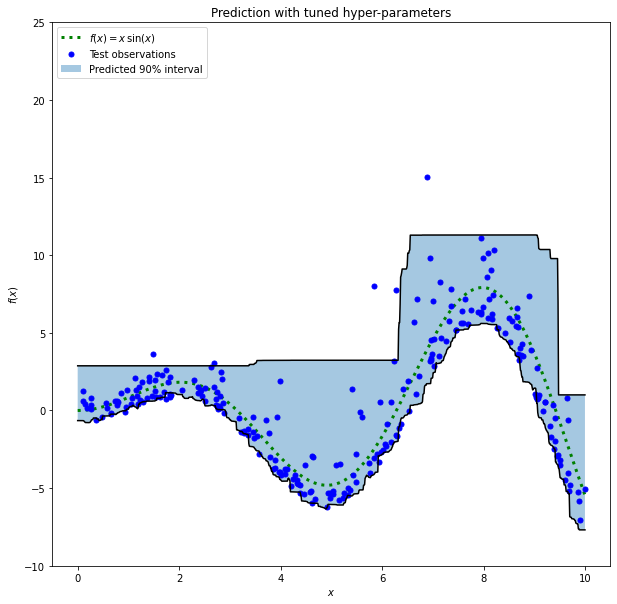

In [20]:
y_lower = search_05p.predict(xx)
y_upper = search_95p.predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), 'g:', linewidth=3, label=r'$f(x) = x\,\sin(x)$')
plt.plot(X_test, y_test, 'b.', markersize=10, label='Test observations')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill_between(xx.ravel(), y_lower, y_upper, alpha=0.4,
                 label='Predicted 90% interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 25)
plt.legend(loc='upper left')
plt.title("Prediction with tuned hyper-parameters")
plt.show()

The plot looks qualitatively better than for the untuned models, especially
for the shape of the of lower quantile.

We now quantitatively evaluate the joint-calibration of the pair of
estimators:

In [21]:
coverage_fraction(y_train,
                  search_05p.predict(X_train),
                  search_95p.predict(X_train))

0.94

In [22]:
coverage_fraction(y_test,
                  search_05p.predict(X_test),
                  search_95p.predict(X_test))

0.9

The calibrated pinball loss on the test set is exactly the expected 90 percent coverage.